In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as pl
import os
import math

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor

from statsmodels.graphics.tsaplots import plot_acf

In [22]:
def function(n_ahead):
    cwd = os.getcwd()
    data = pd.read_csv(cwd + '/datos_TFM_Celia.csv', sep = ',', engine='python')
    data['Time'] = pd.to_datetime(data['Time'])

    data.loc[:,'ws_lag1'] = data['ws'].shift(n_ahead)
    data.loc[:,'Power_lag1'] = data['Power'].shift(n_ahead)
    data.loc[:,'ws_lag2'] = data['ws'].shift(n_ahead+1)
    data.loc[:,'Power_lag2'] = data['Power'].shift(n_ahead+1)

    data.loc[:,'ws_lead1'] = data['ws'].shift(-1)
    data.loc[:,'ws_lead2'] = data['ws'].shift(-2)
    data = data.dropna()

    df_hist = data[data['Time'] < "2013-01-01 01:00:00"]
    df_fut = data[data['Time'] > "2013-01-01 00:00:00"]

    INPUTS = ['ws','wd', 'ws_lag1', 'ws_lag2', 'Power_lag1', 'Power_lag2','ws_lead1','ws_lead2']
    OUTPUT = ['Power']

    X = df_hist[INPUTS]
    y = df_hist[OUTPUT]

    X_train = X.iloc[0:round(0.8*X.shape[0])]
    X_test = X.iloc[round(0.8*X.shape[0])+1:X.shape[0]]
    y_train = y.iloc[0:round(0.8*X.shape[0])]
    y_test = y.iloc[round(0.8*X.shape[0])+1:X.shape[0]]


    X_fut = df_fut[INPUTS]
    y_fut = df_fut[OUTPUT]

    # Train the model with the best parameters
    best_xgb_model = XGBRegressor(
        booster='gbtree',
        objective='reg:squarederror',
        **params_1
    )

    best_xgb_model.fit(X_train, y_train)
    
    # Predict 
    y_pred = best_xgb_model.predict(X_fut)
    df_fut = df_fut.copy()
    df_fut.loc[:, 'XGB_pred'] = y_pred

    # Evaluate the model
    mae = mean_absolute_error(y_fut, y_pred)
    rmse = math.sqrt(mean_squared_error(y_fut, y_pred))

    df_GBMerror.loc[f'horizonte {n_ahead}h'] = [mae, rmse]

    feature_importances = best_xgb_model.feature_importances_
    feature_names = X_train.columns

    # Crear un DataFrame para visualizar las importancias
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Mostrar la importancia de las características
    print(importance_df)

    booster = best_xgb_model.get_booster()
    trees = booster.get_dump(with_stats=True)
    num_params = sum(tree.count('\n') for tree in trees)
    print(f'Número de parámetros ajustados (nodos): {num_params}')

    return df_fut


# Optimizar params

In [5]:
n_ahead = 1

cwd = os.getcwd()
data = pd.read_csv(cwd + '/datos_TFM_Celia.csv', sep = ',', engine='python')
data['Time'] = pd.to_datetime(data['Time'])

data.loc[:,'ws_lag1'] = data['ws'].shift(n_ahead)
data.loc[:,'Power_lag1'] = data['Power'].shift(n_ahead)
data.loc[:,'ws_lag2'] = data['ws'].shift(n_ahead+1)
data.loc[:,'Power_lag2'] = data['Power'].shift(n_ahead+1)

data.loc[:,'ws_lead1'] = data['ws'].shift(-1)
data.loc[:,'ws_lead2'] = data['ws'].shift(-2)
data = data.dropna()

df_hist = data[data['Time'] < "2013-01-01 01:00:00"]
df_fut = data[data['Time'] > "2013-01-01 00:00:00"]

INPUTS = ['ws','wd', 'ws_lag1', 'ws_lag2', 'Power_lag1', 'Power_lag2','ws_lead1','ws_lead2']
OUTPUT = ['Power']

X = df_hist[INPUTS]
y = df_hist[OUTPUT]

X_train = X.iloc[0:round(0.8*X.shape[0])]
X_test = X.iloc[round(0.8*X.shape[0])+1:X.shape[0]]
y_train = y.iloc[0:round(0.8*X.shape[0])]
y_test = y.iloc[round(0.8*X.shape[0])+1:X.shape[0]]


In [6]:
param_grid = {
    'eta': [0.001, 0.01, 0.05, 0.1, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 10, 11],
    'min_child_weight': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'lambda': [0, 0.01, 0.1, 1, 10]
}

# Define the model
xgb_reg = XGBRegressor(
    booster='gbtree',
    #objective='reg:squarederror',
    objective='reg:absoluteerror',
)

# Set up the grid search
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=10,  # Number of cross-validation folds
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters found: ", best_params)

Fitting 10 folds for each of 5400 candidates, totalling 54000 fits
Best parameters found:  {'eta': 0.1, 'lambda': 10, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 1.0}


In [7]:
#params_0 =  {'colsample_bytree': 1.0, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200, 'subsample': 0.6}
#params_1 =  {'colsample_bytree': 1.0, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.8}

params_1 =  {'eta': 0.1, 'lambda': 10, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 1.0}


# Predicción

In [24]:
df_GBMerror = pd.DataFrame(columns=['MAE','RMAE'])
horizons = 10
for i in range(horizons):
    function(i+1)
df_GBMerror

      Feature  Importance
4  Power_lag1    0.939508
7    ws_lead2    0.022327
6    ws_lead1    0.010640
5  Power_lag2    0.006438
0          ws    0.006189
1          wd    0.005970
2     ws_lag1    0.004638
3     ws_lag2    0.004290
Número de parámetros ajustados (nodos): 4438
      Feature  Importance
4  Power_lag1    0.852255
7    ws_lead2    0.057459
6    ws_lead1    0.028088
0          ws    0.026406
1          wd    0.012572
5  Power_lag2    0.008641
2     ws_lag1    0.007680
3     ws_lag2    0.006898
Número de parámetros ajustados (nodos): 4438
      Feature  Importance
4  Power_lag1    0.711788
7    ws_lead2    0.099213
0          ws    0.096846
6    ws_lead1    0.047534
1          wd    0.017545
5  Power_lag2    0.009992
2     ws_lag1    0.008943
3     ws_lag2    0.008139
Número de parámetros ajustados (nodos): 4404
      Feature  Importance
0          ws    0.414877
4  Power_lag1    0.346704
7    ws_lead2    0.140239
6    ws_lead1    0.049150
1          wd    0.020015
5  Powe

,MAE,RMAE
horizonte 1h,0.061744,0.094030
horizonte 2h,0.087695,0.127236
horizonte 3h,0.102387,0.144569
horizonte 4h,0.112040,0.155397
horizonte 5h,0.118709,0.162588
horizonte 6h,0.122598,0.166335
horizonte 7h,0.125229,0.168670
horizonte 8h,0.127032,0.170803
horizonte 9h,0.129180,0.173463
horizonte 10h,0.129388,0.173478


In [11]:
df_GBMerror.to_csv('GBM_Resultados.csv', index=False)

## evaluar un horizonte

      Feature  Importance
4  Power_lag1    0.939508
7    ws_lead2    0.022327
6    ws_lead1    0.010640
5  Power_lag2    0.006438
0          ws    0.006189
1          wd    0.005970
2     ws_lag1    0.004638
3     ws_lag2    0.004290
Número de parámetros ajustados (nodos): 4438


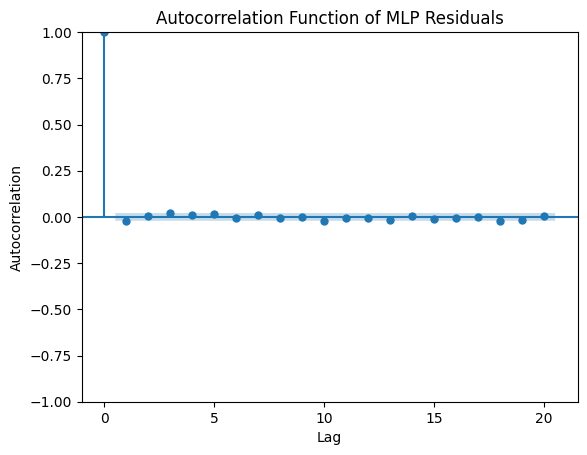

In [23]:
horizonte = 1

df_fut = function(horizonte)
df_fut['Producción Real'] = df_fut['Power']
df_fut['GBM'] = df_fut['XGB_pred']

fig = pl.line(df_fut, x='Time', y=["Producción Real","GBM"])
fig.show()

# Obtener residuos del modelo MLP
residuals = df_fut['Power'] - df_fut['XGB_pred']

# Calcular la función de autocorrelación de los residuos
plot_acf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function of MLP Residuals')
plt.show()